<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Avance-3/JSON_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

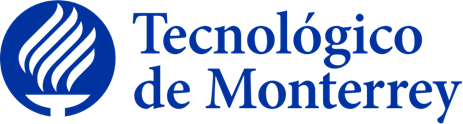

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

### Domingo 19 de mayo de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

### 1. Libraries

First, we'll install and load the libraries that we will be using for this project.

In [226]:
#Let's install a couple of libraries that we'll use
#%%capture
!pip install -q -U google-generativeai
!pip install python-dotenv

35404.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
35412.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [227]:
import os
import google.generativeai as genai
# %load_ext cudf.pandas
import pandas as pd
from dotenv import load_dotenv
from zipfile import ZipFile
import requests
import re
import json
from requests.exceptions import RequestException

### 2. Helper Functions 

We also define a few helper functions that we'll use for downloading, reading text, etc.

In [228]:

#The corpus is encoded as latin1, so we must decode it first
def decode_text(text: str) -> str:
    try:
        return text.encode("latin_1").decode("utf-8")
    except UnicodeDecodeError:
        return text.encode("latin_1").decode("utf-8", errors="replace")

#This method removes newlines so it's easier to extract the title
def remove_new_lines(lines: list) -> list:
    clean_text = []
    for line in lines:
        if not isinstance(line, str):
            continue
        line = line.strip(' ')
        if line == '':
            continue

        clean_text.append(decode_text(line))
    
    return clean_text
    
#This method reads the files and execute the methods above
def read_file(file_name:str):
    with open(file_name, encoding='latin_1') as f:
        text = f.read().splitlines()
        clean_text = remove_new_lines(text)
        if len(text) != 0:
            title = clean_text[0]
        return (title, decode_text("\n".join(text)))
    
#Extracts the filename from the response
def extract_filename(r:requests.Response) -> str:
    if "Content-Disposition" in r.headers.keys():
        return re.findall("filename=(.+)", 
                          r.headers["Content-Disposition"])[0]
    else:
        return r.url.split("/")[-1]
    
#Downloads a file
def download_files(urls: list, directory: str):
    filenames = []
    if not os.path.exists(directory):
        os.mkdir(directory)
    for url in urls:
        try:
            with requests.get(url) as r:
                filename = extract_filename(r)
                filenames.append(filename)
                file = open(f'{directory}/{filename}', mode="wb")
                file.write(r.content)
                file.close()
        except RequestException as e:
            print(e)
    return filenames[0] if len(filenames) == 1 else filenames

#Unzips a file
def unzip(filename: str, source_path: str, dest_path: str):
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
    with ZipFile(f'{source_path}/{filename}', 'r') as zObject:
        zObject.extractall(path=dest_path)

### 3. Prepare the dataset

Now we'll proceed to download the dataset we will be using and load the content to a list of dictionaries.

In [229]:
#This is the URL where the dataset for this notebook will be downloaded from
url = 'https://github.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/raw/main/small_dataset.zip'

In [230]:
filename = download_files([url], './')
unzip(filename, './', './tmp')

In [231]:
corpus = []

# Let's get the content from every file in the directory
for path, folders, files in os.walk('./tmp'):
    for file in files:
        if file.endswith('.txt'):
            title ,text =  read_file(os.path.join(path, file))
            
            corpus.append({
                'Title': title,
                'Filename': file,
                'Text': text
            })  

In [232]:
print(f'Total number of documents: {len(corpus)}')

Total number of documents: 11


In [233]:
# Print first 10 lines
for line in corpus[0]['Text'].splitlines()[55:70]:
  print(line)



  

LEY FEDERAL DE RESPONSABILIDAD AMBIENTAL 
 

TEXTO VIGENTE 
Nueva Ley publicada en el Diario Oficial de la Federación el 7 de junio de 2013 

 
 
 
Al margen un sello con el Escudo Nacional, que dice: Estados Unidos Mexicanos.- Presidencia de la 
República. 
 


### 4. Instruction set generation

We'll generate the instruction set that will be used to finetune the model. Since generating instruction datasets is a high-intensive work, we will use Gemini 1.5 to speed up the process. The main drawback of this method is that the generated instructions will not be of high quality, which will have some impact when finetuning our model.

For future work it would be beneficial to generate high-quality instructions using domain experts.

On some other note, we use Google Gemini because is the model that supports the longest context window (currently 1 millon tokens). Other models are way below this number, which means that providing the full text of the documents would have been problematic.

Finally, in our previous deliverable we stated that we would use Bonito, a LLM for generating instrution sets. Nonetheless, after carefully reading the documentation we found that Bonito only supports the english language. Since our corpus is in spanish, the use of Bonito is not viable.

In [234]:
#We need a API key. Please, be sure to have a .env file in the same directory of this notebook.
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')


In [235]:
genai.configure(api_key=GEMINI_API_KEY)

In [236]:
# Create the model
# See https://ai.google.dev/api/python/google/generativeai/GenerativeModel

generation_config = {
  "temperature": 1.5,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
]

Below we define our prompt for Google Gemini

In [237]:
prompt = """
Eres un experto en inteligencia artificial, trabajas en el desarrollo de Large Language Models.
Estás encargado del desarrollo de un modelo de lenguaje experto en el dominio de las leyes mexicanas, para lo cual estás creando un dataset de tipo instruction tuning.
Hasta el momento, has recabado más de 300 leyes mexicanas, de las cuales requieres extraer información relevante y generar el dataset con preguntas y
respuestas basados en los documentos legislativos.
  
Tomando en cuenta el contenido de la ley que compartiré debajo, por favor genera 10 ejemplos de plantillas de tipo "Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting", siguiendo el formato de pares instruction-output.
Ejemplo de Question Answering (QA):
[
{
"instruction": "Según el artículo 22 del Código Civil Federal, ¿desde qué momento entra el individuo concebido bajo la protección de la ley?",
"output": "De acuerdo al artículo 22 del Código Civil Federal, desde el momento en que un individuo es concebido, entra bajo la protección de la ley y se le tiene por
nacido para los efectos declarados en el presente Código."
},
{
"instruction": "¿Qué establece el artículo 23 del Código Civil Federal sobre el ejercicio de derechos de los incapaces?",
"output": "Según el artículo 23 del Código Civil Federal, la minoría de edad, el estado de interdicción y demás incapacidades establecidas por la ley, son
restricciones a la personalidad jurídica que no deben menoscabar la dignidad de la persona ni atentar contra la integridad de la familia; pero los incapaces pueden ejercitar sus derechos o contraer obligaciones por medio de sus representantes."
}
]
Ejemplos de Summarization:
[
{
"instruction": "Resume las obligaciones del Juez del Registro Civil respecto a las actas, según los artículos 43 a 49 del Código Civil Federal.",
"output": "De acuerdo a los artículos 43 a 49 del Código Civil Federal, el Juez del Registro Civil tiene las siguientes obligaciones respecto a las actas: asentar sólo lo
declarado para el acto y previsto en la ley; permitir la representación por mandatario especial; preferir testigos designados por los interesados; evitar falsificación o
inserción de circunstancias prohibidas; corregir vicios o defectos no sustanciales; dar testimonio de actas; y autorizar actas de su propia familia en la adscripción
más próxima."
},
{
"instruction": "Sintetiza lo que establece el Código Civil Federal en los artículos del 86 al 88 sobre la adopción plena.",
"output": "Los artículos 86, 87 y 88 del Código Civil Federal establecen que en la adopción plena se levantará un acta como si fuera de nacimiento, se harán
anotaciones en el acta de nacimiento originaria, la cual quedará reservada. No se publicará ni expedirá constancia alguna que revele el origen del adoptado ni su
condición, salvo providencia judicial. El artículo 88 fue derogado."
}
]
Ejemplos de Legal Advice Generation:
[
{
"instruction": "Si dos personas quieren contraer matrimonio siendo menores de edad, ¿qué requisitos deben cumplir según el Código Civil Federal?",
"output": "De acuerdo al Código Civil Federal, si dos personas menores de edad quieren contraer matrimonio, deben cumplir los siguientes requisitos: 1) Tener al
menos 16 años el hombre y 14 la mujer (art. 148); 2) Obtener el consentimiento de sus padres, abuelos paternos o tutores (arts. 149-155); 3) Solicitar la dispensa del
juez de lo familiar (art. 151); 4) Presentar su solicitud ante el Juez del Registro Civil (art. 97) con la documentación requerida (art. 98). Se recomienda consultar a un
abogado especializado para recibir orientación específica a su caso."
},
{
"instruction": "¿Qué pasos debe seguir una persona para solicitar una acta de nacimiento según el Código Civil Federal?",
"output": "Para solicitar un acta de nacimiento, el Código Civil Federal establece en sus artículos 54 a 76 el siguiente procedimiento: 1) Presentar al recién nacido
ante el Juez del Registro Civil en su oficina o lugar de nacimiento; 2) Los padres o abuelos declaran el nacimiento dentro de los 6 meses siguientes; 3) Si nace en
casa, el jefe de familia tiene obligación de dar aviso; 4) Si nace en un sanatorio,el director o administrador dará aviso; 5) Se levantará el acta de nacimiento con
asistencia de dos testigos, expresándose todos los datos requeridos por la ley. Es importante cumplir los plazos y proporcionar información veraz para evitar
contratiempos posteriores."
}
]
Ejemplos de Legal Document Drafting:
[
{
"instruction": "Redacta una cláusula para un contrato de compraventa de un inmueble, estipulando que las partes se someten a las leyes mexicanas según el
Código Civil Federal.",
"output": "CLÁUSULA DÉCIMA.- LEY APLICABLE. Para todo lo relativo a la interpretación, cumplimiento y ejecución del presente contrato, las partes acuerdan
someterse a las leyes federales de los Estados Unidos Mexicanos, en particular a las disposiciones del Código Civil Federal, según lo establecido en sus artículos 12,
13 y demás relativos y aplicables, renunciando expresamente a cualquier otra ley, fuero o jurisdicción que pudiera corresponderles en virtud de sus domicilios
presentes o futuros."
},
{
"instruction": "Elabora una cláusula para un contrato de arrendamiento especificando que la renta se incrementará anualmente conforme al Código Civil Federal.",
"output": "CLÁUSULA DÉCIMA.- INCREMENTO DE LA RENTA. Las partes acuerdan que la renta pactada en la cláusula X del presente contrato se incrementará anualmente
de manera automática, aplicando el porcentaje de aumento que corresponda al Índice Nacional de Precios al Consumidor (INPC) publicado por el Banco de México.
Lo anterior con fundamento en lo dispuesto por el artículo 2448-J del Código Civil Federal. El arrendador notificará por escrito al arrendatario, con al menos 30
días de anticipación, el monto de la renta actualizada que entrará en vigor en la fecha de aniversario del contrato."
}
]
Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting"):
"""

In [238]:
model = genai.GenerativeModel(
  model_name="gemini-1.5-flash-latest",
  safety_settings=safety_settings,
  generation_config=generation_config,
  system_instruction= prompt,
)

In [239]:
history = [
    {
      "role": "user",
      "parts": [
        "¿Quién eres?",
      ],
    },
    {
      "role": "model",
      "parts": [
        "Soy un experto en inteligencia artificial, trabajo en el desarrollo de Large Language Models.",
      ],
    },
  ]

We now loop through every document and send the prompt and the document text to Google Gemini. Sometimes, Google Gemini might throw a recitation error. The reason of why this occurs is not entirely known, but it seems that some content is being flagged for unauthorized citations.

Please, be aware that the following step might take around 10-15 minutes to execute.

In [240]:
outputs = {}
errors = []

for item in corpus:

    try:
        chat_session = model.start_chat(history=history)
        msg = "Extrae el JSON para la siguiente ley:\n---\n" + \
            item['Text'] + "---"
        json_output = chat_session.send_message(msg)
        #Let's format the output to get a valid json
        result = re.sub(r"(json\n|`{3})", "",
                        json_output.text, 0, re.MULTILINE)
        outputs[item['Title']] = json.loads(result)
    
    #Sometimes Google Gemini might throw a recitation error
    except Exception as e:
        errors.append(
            {'title': item['Title'], 
             'error': e, 
             'error_msg': str(e)})
        continue

In [241]:
print(f'Number of files processed correctly: {len(outputs)}\n'\
    f'Number of files with errors: {len(errors)}')

Number of files processed correctly: 6
Number of files with errors: 5


In [242]:
print (outputs)

{'Ley Federal de Responsabilidad Ambiental': [{'instruction': 'Según el artículo 1o. de la Ley Federal de Responsabilidad Ambiental (LFRA), ¿qué regula esta ley?', 'output': 'La LFRA regula la responsabilidad ambiental que surge por daños ocasionados al ambiente, incluyendo su reparación y compensación a través de procesos judiciales federales, mecanismos alternativos de resolución de conflictos, procedimientos administrativos y aquellos relacionados con delitos contra el ambiente y la gestión ambiental.'}, {'instruction': 'Resume los objetivos y principios clave de la Ley Federal de Responsabilidad Ambiental.', 'output': 'La Ley Federal de Responsabilidad Ambiental busca proteger, preservar y restaurar el ambiente y el equilibrio ecológico, asegurando el derecho humano a un medio ambiente sano para el desarrollo y bienestar de todas las personas. Reconoce la responsabilidad individual por los daños ambientales, considerando que estos son independientes del daño patrimonial sufrido por

Finally, we write the output to a file

In [246]:
with open('instruction_set.json', mode='wt') as f:
    f.write(json.dumps(outputs))

### 5. Conclusions

In this notebook we generated a few instruction sets to be used when finetuning our model. Since generating instruction sets requires resources that we currently don't have, such as domain experts, quality verification, etc. we had to use Google Gemini.

Since these instruction sets are not considered of high quality, it's expected to have some impact in our final model. Nonetheless, for the purpose of this activity this sets will be sufficient. Our next step would be to generate more instruction sets, since the ones generated in this notebook only considered a few laws in order to minimize the execution time of this notebook.